# analyze.fit.result.ipynb
- 22.10.10
- Gregory S.H. Paek

In [128]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [129]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

- Function

In [130]:
def make_confusion_matrix(arr0, arr1, alarr0, alarr1):
	"""
	arr0 (x-axis)
	arr1 (y-axis)

	alarr0
	alarr1
	"""
	# blank lists
	conflist = []
	conflist_all = []

	# iteration
	# y-axis (top --> down)
	for val1 in np.flipud(np.unique(arr1)):
		xlist = []
		xlist_all = []
		# x-axis (left --> right)
		for val0 in np.unique(arr0):
			# the number of consistent models
			nparam = len(arr0[(arr0==val0) & (arr1==val1)])
			# the number of all models
			nall = len(alarr0[(alarr0==val0) & (alarr1==val1)])
			xlist.append(nparam)
			xlist_all.append(nall)
		# stack the matrix
		conflist.append(xlist)
		conflist_all.append(xlist_all)

	# confusion matrix
	conf_matrix = np.array(conflist)
	conf_matrix_all = np.array(conflist_all)

	return (conf_matrix, conf_matrix_all)

In [131]:
def put_kn_model_info(intbl, verbose=False):
	# intbl = lstbl
	# verbose = False
	intbl['dshape'] = ' '*20
	intbl['lat'] = ' '*20
	intbl['md'] = 0.
	intbl['vd'] = 0.
	intbl['mw'] = 0.
	intbl['vw'] = 0.
	intbl['angle'] = 0.
	intbl['d'] = 0.

	inobs = lstbl['obs'][0]
	for ii, inobs in enumerate(lstbl['obs']):
		part = inobs.split('_')

		#	Shape
		if part[1] == 'TP':
			dshape = 'TP'
		elif part[1] == 'TS':
			dshape = 'TS'
		else:
			dshape = ''

		#	Latitude
		if part[5] == 'wind1':
			lat = 'Axial'
		elif part[5] == 'wind2':
			lat = 'Edge'
		else:
			lat = ''

		#	Ejecta mass for low-Ye [solar mass]
		md = float(part[7].replace('md', ''))

		#	Ejecta velocity for low-Ye [N*c]
		vd = float(part[8].replace('vd', ''))

		#	Ejecta mass for high-Ye [solar mass]
		mw = float(part[9].replace('mw', ''))

		#	Ejecta velocity for high-Ye [N*c]
		vw = float(part[10].replace('vw', ''))

		#	Angle [deg]
		angle = float(part[11].replace('angle', ''))

		#	Distance [Mpc]
		d = float(part[15].replace('d', ''))

		if verbose:
			print(f'dshape : {dshape}')
			print(f'lat    : {lat}')
			print(f"md     : {md}")
			print(f"vd     : {vd}")
			print(f"mw     : {mw}")
			print(f"vw     : {vw}")
			print(f"angle  : {angle}")
			print(f"d      : {d}")
		else:
			pass
		
		intbl['dshape'][ii] = dshape
		intbl['lat'][ii] = lat
		intbl['md'][ii] = md
		intbl['vd'][ii] = vd
		intbl['mw'][ii] = mw
		intbl['vw'][ii] = vw
		intbl['angle'][ii] = angle
		intbl['d'][ii] = d
	return intbl

- Read the result tables

In [132]:
#	LSST
lstbl = Table.read('../5.result/fit_kn2all/lsst/fit.fits')
#	KMTNet
kmtbl = Table.read('../5.result/fit_kn2all/kmtnet/fit.fits')
#	7DT
sdtbl = Table.read('../5.result/fit_kn2all/7dt/fit.fits')

In [133]:
tag = 'lsst'
d = 40

In [134]:
lstbl = put_kn_model_info(lstbl, verbose=False)
lstbl

seed,obs,t,g-r,(g-r)err,r-i,(r-i)err,kn_bestfit,kn_t,kn_compare_models,kn_chisq,kn_rchisq,kn_popt,kn_dof,cmp_bestfit,cmp_t,cmp_compare_models,cmp_chisq,cmp_rchisq,cmp_popt,cmp_dof,identification,dshape,lat,md,vd,mw,vw,angle,d
,,d,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes107,float64,float64,float64,float64,float64,bytes200,float64,int64,float64,float64,float64,int64,bytes200,float64,int64,float64,float64,float64,int64,bool,str20,str20,float64,float64,float64,float64,float64,float64
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.125,0.0,0.0,0.0,0.0,,0.0,267,0.0,0.0,0.0,0,,0.0,16,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,0.262462545211573,0.12205503138085355,-0.1532002751974666,0.15060379070480906,Run_TS_dyn_all_lanth_wind1_all_md0.1_vd0.3_mw0.03_vw0.3_angle180_synphot_lsst.ecsv,0.25,267,1.3142939716171367,0.32857349290428417,5.033837276221477e-14,4,v19-2009ip-corr_v1.0_type_IIn_sn_z0.001_synphot_lsst.ecsv,30.0,16,0.8120279017968068,0.2030069754492017,5.0784314804293134e-05,4,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.5,-0.05682223376942375,0.08311059551847032,0.08236380344346017,0.10449351139788024,Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.3_mw0.01_vw0.15_angle60_synphot_lsst.ecsv,0.5,267,1.233436952003863,0.24668739040077262,5.920044544097892e-13,5,v19-2007pk-corr_v1.0_type_IIn_sn_z0.1_synphot_lsst.ecsv,5.0,16,2.983126731097946,0.5966253462195892,0.5132082990536271,5,True,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.0,1.1732383617187807,0.1627151106148356,0.33269683493540825,0.13908254139432025,Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.05_mw0.003_vw0.3_angle60_synphot_lsst.ecsv,1.0,267,1.6922238210807883,0.42305595527019707,9.97012148556033e-13,4,v19-2004gt-corr_v1.0_type_Ic_sn_z0.1_synphot_lsst.ecsv,40.0,16,11.374996524363114,2.8437491310907785,0.37516410765423513,4,True,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.542,0.0,0.0,0.0,0.0,,0.0,267,0.0,0.0,0.0,0,,0.0,16,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,2.0,0.0,0.0,0.0,0.0,,0.0,267,0.0,0.0,0.0,0,,0.0,16,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.125,0.0,0.0,0.0,0.0,,0.0,136,0.0,0.0,0.0,0,,0.0,39,0.0,0.0,0.0,0,False,TP,Axial,0.001,0.05,0.001,0.05,120.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,0.11928416380614593,0.11551972746911543,-0.16444100461340483,0.1478558102492556,Run_TS_dyn_all_lanth_wind1_all_md0.003_vd0.15_mw0.03_vw0.05_angle0_synphot_lsst.ecsv,0.25,136,0.09566563825444871,0.023916409563612177,7.178566079489055e-13,4,v19-2007pk-corr_v1.0_type_IIn_sn_z0.0001_synphot_lsst.ecsv,10.0,39,1.5008081763910572,0.3752020440977643,2.815069214948893e-07,4,True,TP,Axial,0.001,0.05,0.001,0.05,120.0,40.0


- keys

In [135]:
print(lstbl.keys())

['seed', 'obs', 't', 'g-r', '(g-r)err', 'r-i', '(r-i)err', 'kn_bestfit', 'kn_t', 'kn_compare_models', 'kn_chisq', 'kn_rchisq', 'kn_popt', 'kn_dof', 'cmp_bestfit', 'cmp_t', 'cmp_compare_models', 'cmp_chisq', 'cmp_rchisq', 'cmp_popt', 'cmp_dof', 'identification', 'dshape', 'lat', 'md', 'vd', 'mw', 'vw', 'angle', 'd']


### Filter low SNR in g, r, i (or corresponding bands)
- indx_skip : low SNR
- indx_nskin : higher SNR than 5

In [136]:
indx_skip = np.where(
	(lstbl['g-r']==0.0) &
	(lstbl['r-i']==0.0) &
	(lstbl['(g-r)err']==0.0) &
	(lstbl['(r-i)err']==0.0)
)

indx_nskip = np.where(
	(lstbl['g-r']!=0.0) &
	(lstbl['r-i']!=0.0) &
	(lstbl['(g-r)err']!=0.0) &
	(lstbl['(r-i)err']!=0.0)
)

# lstbl[indx_skip]
# lstbl[indx_nskip]

print(f"gri SNR>=5 Case : {len(lstbl[indx_nskip])}")

lstbl0 = lstbl[indx_nskip]

gri SNR>=5 Case : 30815


In [137]:
print("# Skip Case")
print(f"Mean mw : {np.mean(lstbl['mw'][indx_skip]):1.3f}")
print(f"Mean md : {np.mean(lstbl['md'][indx_skip]):1.3f}")

print("# No skip Case")
print(f"Mean mw : {np.mean(lstbl['mw'][indx_nskip]):1.3f}")
print(f"Mean md : {np.mean(lstbl['md'][indx_nskip]):1.3f}")



# Skip Case
Mean mw : 0.011
Mean md : 0.018
# No skip Case
Mean mw : 0.033
Mean md : 0.031


- Filter cases; only KN was compared

In [138]:
print(f"Total             : {len(lstbl0)}")
print(f"KN fit    == True : {len(lstbl0[~lstbl0['cmp_chisq'].mask])}")
print(f"Other fit == True : {len(lstbl0[~lstbl0['kn_chisq'].mask])}")
print(f"Both fit  == True : {len(lstbl0[(~lstbl0['cmp_chisq'].mask) & (~lstbl0['kn_chisq'].mask)])}")

Total             : 30815
KN fit    == True : 16329
Other fit == True : 29994
Both fit  == True : 16204


In [139]:
# filtered lsst table
flstbl = lstbl0[(~lstbl0['cmp_chisq'].mask) & (~lstbl0['kn_chisq'].mask)]
flstbl[:5]

seed,obs,t,g-r,(g-r)err,r-i,(r-i)err,kn_bestfit,kn_t,kn_compare_models,kn_chisq,kn_rchisq,kn_popt,kn_dof,cmp_bestfit,cmp_t,cmp_compare_models,cmp_chisq,cmp_rchisq,cmp_popt,cmp_dof,identification,dshape,lat,md,vd,mw,vw,angle,d
,,d,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes107,float64,float64,float64,float64,float64,bytes200,float64,int64,float64,float64,float64,int64,bytes200,float64,int64,float64,float64,float64,int64,bool,str20,str20,float64,float64,float64,float64,float64,float64
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,0.262462545211573,0.12205503138085355,-0.1532002751974666,0.15060379070480906,Run_TS_dyn_all_lanth_wind1_all_md0.1_vd0.3_mw0.03_vw0.3_angle180_synphot_lsst.ecsv,0.25,267,1.3142939716171367,0.32857349290428417,5.033837276221477e-14,4,v19-2009ip-corr_v1.0_type_IIn_sn_z0.001_synphot_lsst.ecsv,30.0,16,0.8120279017968068,0.2030069754492017,5.0784314804293134e-05,4,False,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.5,-0.05682223376942375,0.08311059551847032,0.08236380344346017,0.10449351139788024,Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.3_mw0.01_vw0.15_angle60_synphot_lsst.ecsv,0.5,267,1.233436952003863,0.24668739040077262,5.920044544097892e-13,5,v19-2007pk-corr_v1.0_type_IIn_sn_z0.1_synphot_lsst.ecsv,5.0,16,2.983126731097946,0.5966253462195892,0.5132082990536271,5,True,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_lsst_obs_d40_iter10.lsst.ecsv,1.0,1.1732383617187807,0.1627151106148356,0.33269683493540825,0.13908254139432025,Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.05_mw0.003_vw0.3_angle60_synphot_lsst.ecsv,1.0,267,1.6922238210807883,0.42305595527019707,9.97012148556033e-13,4,v19-2004gt-corr_v1.0_type_Ic_sn_z0.1_synphot_lsst.ecsv,40.0,16,11.374996524363114,2.8437491310907785,0.37516410765423513,4,True,TP,Axial,0.001,0.05,0.001,0.05,0.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.25,0.11928416380614593,0.11551972746911543,-0.16444100461340483,0.1478558102492556,Run_TS_dyn_all_lanth_wind1_all_md0.003_vd0.15_mw0.03_vw0.05_angle0_synphot_lsst.ecsv,0.25,136,0.09566563825444871,0.023916409563612177,7.178566079489055e-13,4,v19-2007pk-corr_v1.0_type_IIn_sn_z0.0001_synphot_lsst.ecsv,10.0,39,1.5008081763910572,0.3752020440977643,2.815069214948893e-07,4,True,TP,Axial,0.001,0.05,0.001,0.05,120.0,40.0
0,Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_lsst_obs_d40_iter10.lsst.ecsv,0.5,-0.12107689461240412,0.07887892334073125,-0.28528228343171236,0.10461748829686736,Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.3_mw0.1_vw0.3_angle150_synphot_lsst.ecsv,0.5,136,0.20416657322290216,0.04083331464458043,9.972582128052687e-14,5,hsiao_v3.0_type_Ia_sn_z0.1_synphot_lsst.ecsv,0.0,39,10.176987401736945,2.035397480347389,0.6058462121208893,5,True,TP,Axial,0.001,0.05,0.001,0.05,120.0,40.0


0.601


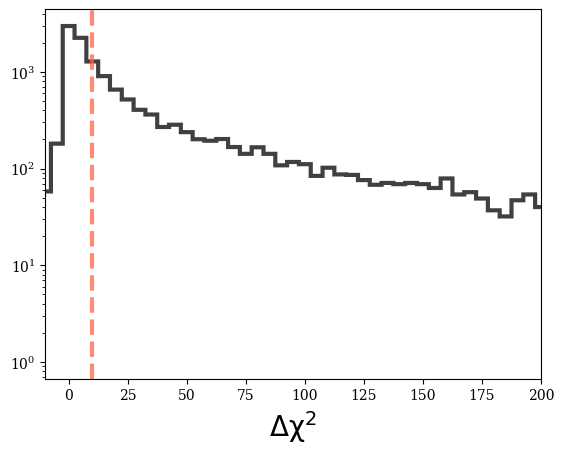

In [140]:
del_rchisq = flstbl['cmp_rchisq'] - flstbl['kn_rchisq']
flstbl['del_rchisq'] = del_rchisq

bins = np.arange(del_rchisq.min(), del_rchisq.max()+5, 5)
_ = plt.hist(del_rchisq, color='k', bins=bins, histtype='step', lw=3, alpha=0.75)
plt.axvline(x=10, ls='--', color='tomato', lw=3, alpha=0.75)
_ = plt.yscale('log')
_ = plt.xlabel(r'$\rm \Delta \chi^{2}$')
plt.xlim([-10, 200])

ratio = len(del_rchisq[del_rchisq>=10])/len(del_rchisq)
print(f"{ratio:1.3f}")

t=0.125 5.391
t=0.250 14.466
t=0.500 30.523
t=1.000 32.651
t=1.542 46.175
t=2.000 56.804


/Users/paek/opt/miniconda3/envs/kn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$\\rm \\chi^{2}_{other}-\\chi^{2}_{KN}$')

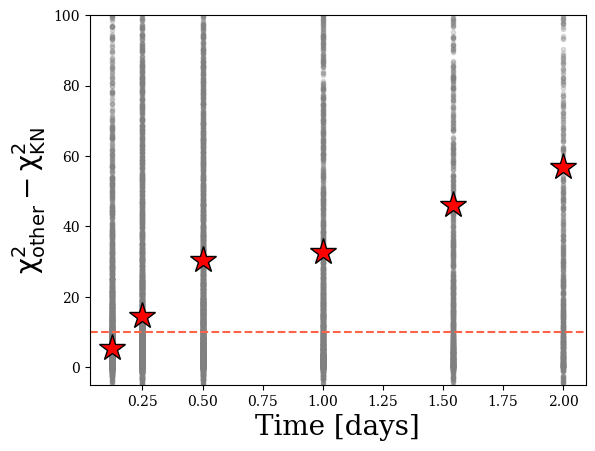

In [141]:
times = np.unique(flstbl['t'])
for t in times:
	tflstbl = flstbl[flstbl['t']==t]
	med = np.median(tflstbl['del_rchisq'])
	plt.plot([t]*len(tflstbl), tflstbl['del_rchisq'], color='grey', ls='none', marker='.', alpha=0.25)
	# plt.boxplot(tflstbl['del_rchisq'])
	plt.plot(t, med, marker='*', color='red', ms=20, mec='k')
	print(f"t={t:1.3f} {med:1.3f}")

plt.axhline(y=10, ls='--', color='tomato')
plt.ylim([-5, 100])
plt.xlabel('Time [days]')
plt.ylabel(r'$\rm \chi^{2}_{other}-\chi^{2}_{KN}$')

t=0.000 25.620
t=30.000 21.099
t=60.000 14.446
t=90.000 13.343
t=120.000 13.730
t=150.000 20.512
t=180.000 26.036


Text(0, 0.5, '$\\rm \\chi^{2}_{other}-\\chi^{2}_{KN}$')

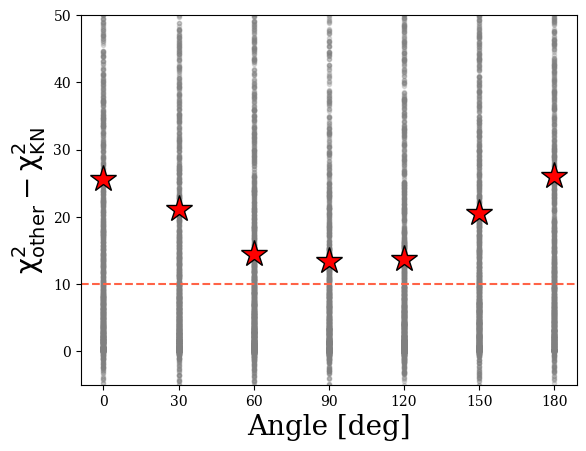

In [142]:
angles = np.unique(flstbl['angle'])
for ang in angles:
	tflstbl = flstbl[flstbl['angle']==ang]
	med = np.median(tflstbl['del_rchisq'])
	plt.plot([ang]*len(tflstbl), tflstbl['del_rchisq'], color='grey', ls='none', marker='.', alpha=0.25)
	# plt.boxplot(tflstbl['del_rchisq'])
	plt.plot(ang, med, marker='*', color='red', ms=20, mec='k')
	print(f"t={ang:1.3f} {med:1.3f}")

plt.axhline(y=10, ls='--', color='tomato')
plt.ylim([-5, 50])
plt.xticks(np.arange(0, 180+30, 30))
plt.xlabel('Angle [deg]')
plt.ylabel(r'$\rm \chi^{2}_{other}-\chi^{2}_{KN}$')

# Which transients are the most confused?

- identification or not, whatever

In [143]:
def put_comparison_model_info(intbl, key='model'):

	intbl['cmp_model_name'] = ' '*100
	intbl['ver'] = ' '*100
	intbl['typ'] = ' '*100
	intbl['z'] = 0.0

	# cmpmdl = cmptbl['model'][0]
	for ii, cmpmdl in enumerate(intbl[key]):
		part = cmpmdl.split('_')

		mdl = part[0]
		ver = part[1].replace('v', '')
		typ = part[3]
		try:
			z = float(part[5].replace('z', ''))
		except:
			# print(ii, cmpmdl)
			z = 0.0

		intbl['cmp_model_name'][ii] = mdl
		intbl['ver'][ii] = ver
		intbl['typ'][ii] = typ
		intbl['z'][ii] = z

	return intbl

In [144]:
cmptbl = Table()
cmpmodels = np.unique(flstbl['cmp_bestfit'])
# cmptimes = np.unique(flstbl['cmp_t'])
cmptbl['model'] = cmpmodels
cmptbl['n'] = 0

# for kk, (cmpmdl, t) in enumerate(zip(cmpmodels, cmptimes)):
for kk, cmpmdl in enumerate(cmptbl['model']):
	n_mdl = len(flstbl[
		(flstbl['cmp_bestfit']==cmpmdl)
	])
	# print(kk, cmpmdl, n_mdl)
	cmptbl['n'][kk] = n_mdl

cmptbl = cmptbl[np.argsort(-1*cmptbl['n'])]
cmptbl = put_comparison_model_info(cmptbl)

ntop = 10
print(f'# Top {ntop}')
for mm, mdl in enumerate(cmptbl['cmp_model_name'][:ntop]):
	n = cmptbl['n'][mm]
	typ = cmptbl['typ'][mm]
	print(mm+1, mdl, f"Type {typ} SN ({n})")

# Top 10
1 v19-2009ip-corr Type IIn SN (1287)
2 v19-1999em-corr Type IIP SN (1070)
3 v19-2009ip-corr Type IIn SN (1067)
4 v19-2007pk-corr Type IIn SN (1056)
5 v19-2009ip-corr Type IIn SN (734)
6 v19-1993j-corr Type IIb SN (555)
7 v19-2004gt-corr Type Ic SN (550)
8 v19-2007pk-corr Type IIn SN (548)
9 v19-2004et-corr Type IIP SN (539)
10 nugent-sn2l Type IIL SN (535)


- Number for each type

In [145]:
#	Consider SN rate
snrtbl = ascii.read('../3.table/snrate_Li+12.tsv')

wnlist = []
for typ in np.unique(cmptbl['typ']):
	n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	if typ in snrtbl['type']:
		wn = n*snrtbl['ratio'][snrtbl['type']==typ].item()
		print(f"{typ}\t{n}\t--> {wn:1.1f}")
		wnlist.append(wn)

IIL	1422	--> 81.1
IIP	3868	--> 1543.3
IIb	1533	--> 104.9
IIn	6022	--> 308.9
Ia	1118	--> 268.3
Ib	659	--> 26.3
Ic	1582	--> 162.3


- Top 10
1 v19-2009ip-corr Type IIn SN (1287)
2 v19-1999em-corr Type IIP SN (1070)
3 v19-2009ip-corr Type IIn SN (1067)
4 v19-2007pk-corr Type IIn SN (1056)
5 v19-2009ip-corr Type IIn SN (734)
6 v19-1993j-corr Type IIb SN (555)
7 v19-2004gt-corr Type Ic SN (550)
8 v19-2007pk-corr Type IIn SN (548)
9 v19-2004et-corr Type IIP SN (539)
10 nugent-sn2l Type IIL SN (535)

IIL 1422
IIP 3868
IIb 1533
IIn 6022
Ia 1118
Ib 659
Ic 1582


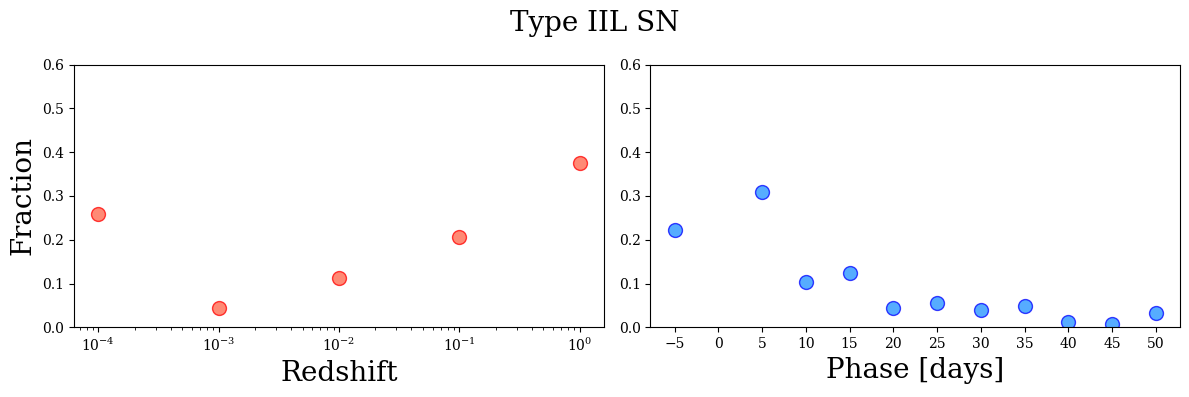

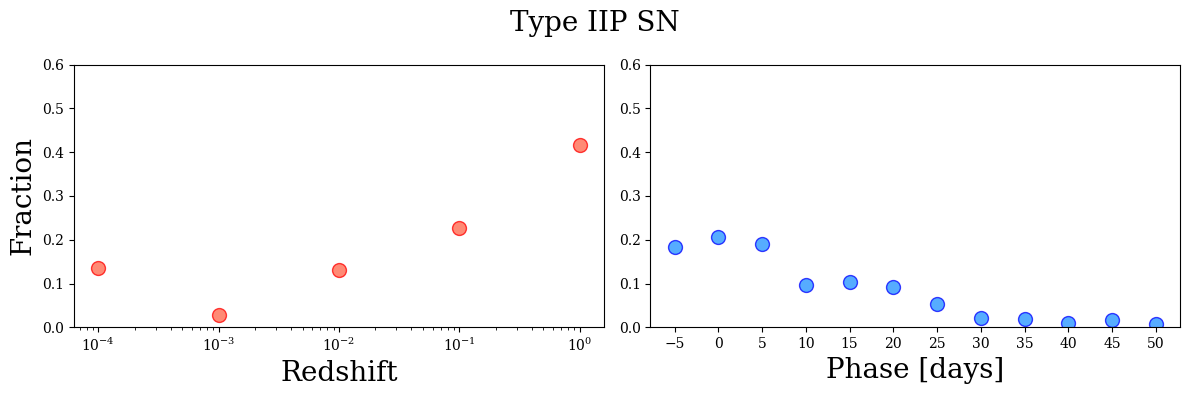

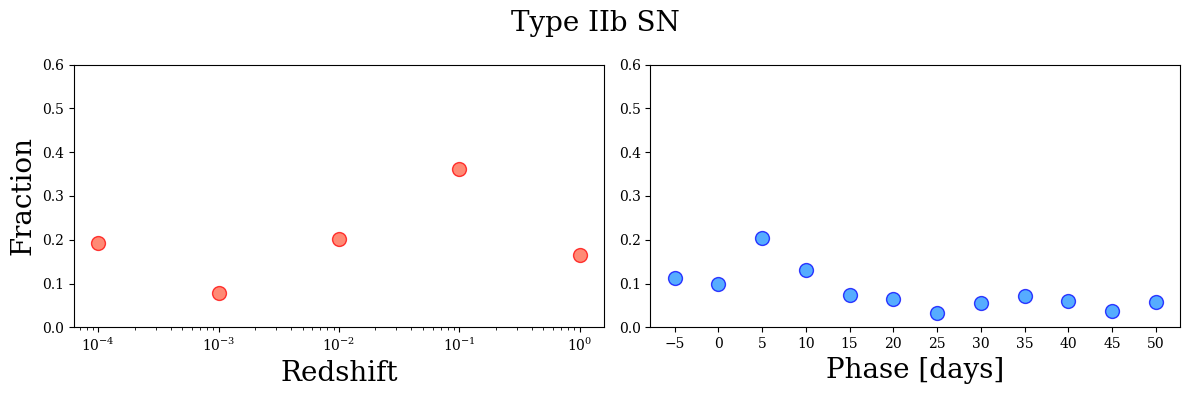

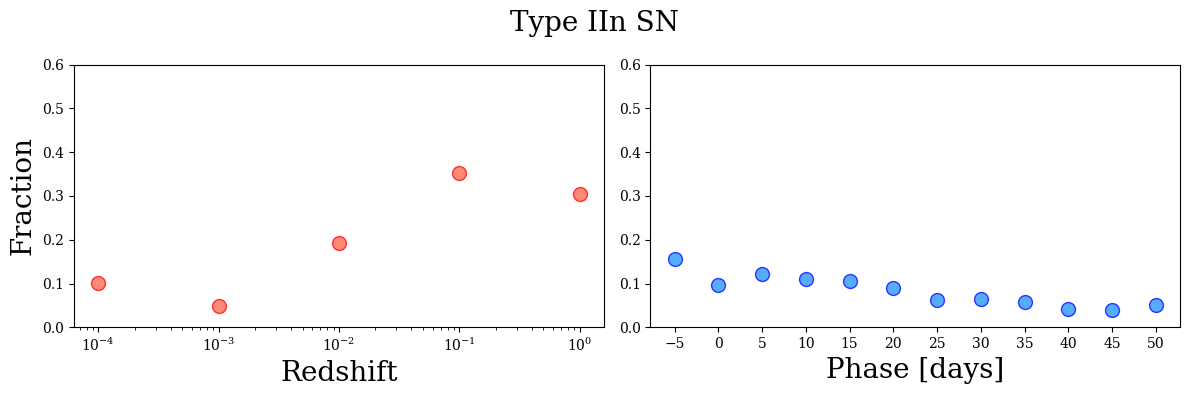

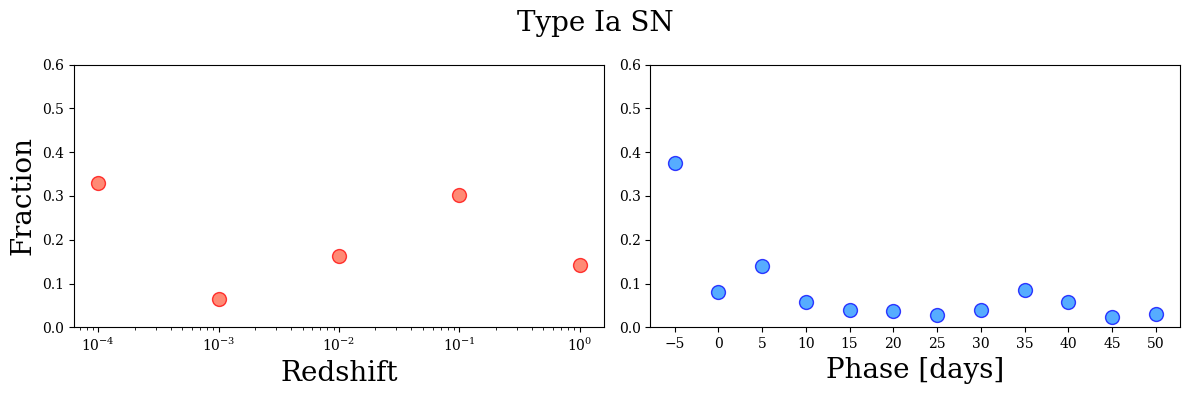

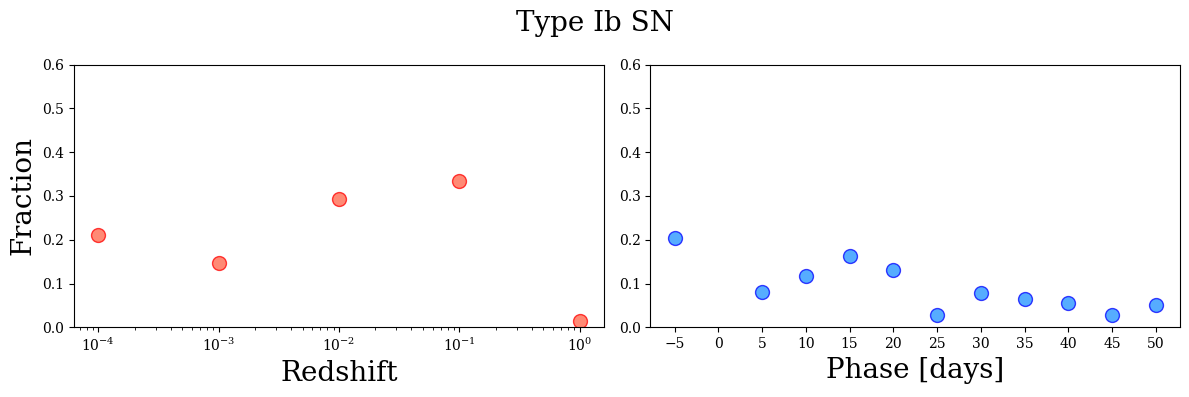

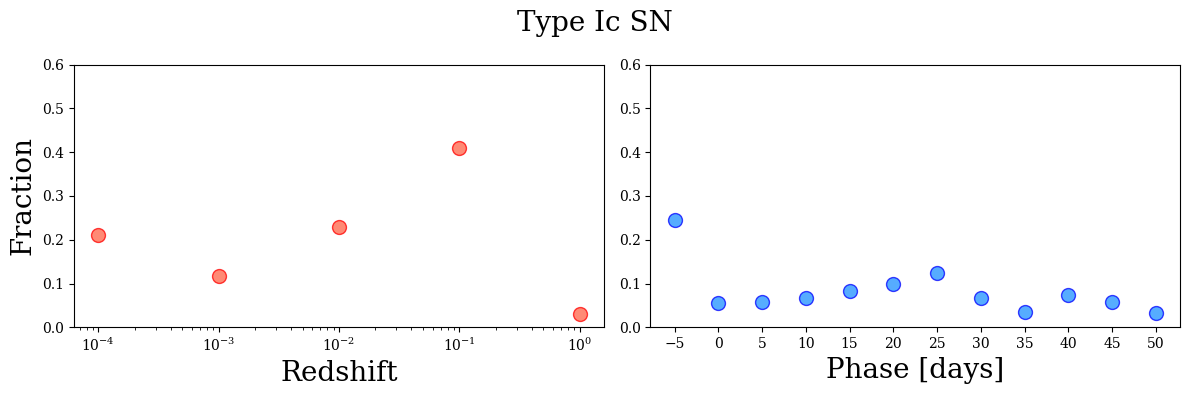

In [146]:
yu = 0.6
mflstbl = put_comparison_model_info(flstbl, key='cmp_bestfit')

for typ in np.unique(cmptbl['typ']):
	n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	print(typ, n)


	# typ = 'IIP'
	tmptbl = mflstbl[mflstbl['typ']==typ]

	zarr = np.unique(tmptbl['z'])
	tarr = np.unique(tmptbl['cmp_t'])

	fig = plt.figure(figsize=(12, 4))
	plt.suptitle(f"Type {typ} SN", fontsize=20)
	plt.subplot(1, 2, 1)
	# plt.title('Redshift')
	plt.plot(zarr, [len(tmptbl[tmptbl['z']==z])/len(tmptbl) for z in zarr], marker='o', ms=10, ls='none', color='tomato', mec='red', alpha=0.75)
	plt.xlabel('Redshift')
	plt.xscale('log')
	plt.ylabel('Fraction')
	plt.ylim([0, yu])

	plt.subplot(1, 2, 2)
	plt.plot(tarr, [len(tmptbl[tmptbl['cmp_t']==t])/len(tmptbl) for t in tarr], marker='o', ms=10, ls='none', color='dodgerblue', mec='blue', alpha=0.75)
	plt.xlabel('Phase [days]')
	plt.ylim([0, yu])
	plt.xticks(np.arange(-5, 50+5, 5))

	plt.tight_layout()
	# plt.xscale('log')
	plt.savefig(f'../5.result/fit_kn2all/{tag}/type_{typ}_sn_dependence.png',)



(0.0, 0.6)

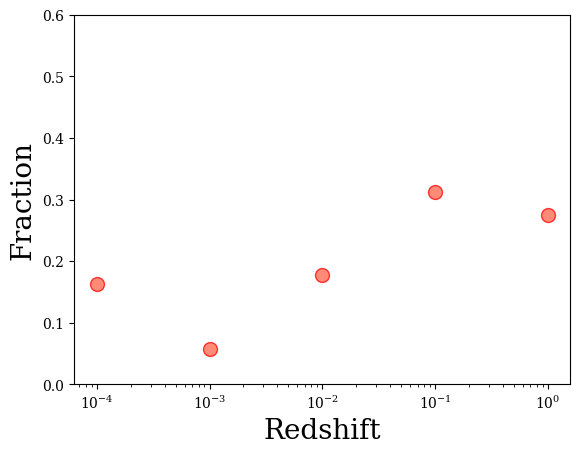

In [147]:
plt.plot(zarr, [len(mflstbl[mflstbl['z']==z])/len(mflstbl) for z in zarr], marker='o', ms=10, ls='none', color='tomato', mec='red', alpha=0.75)
plt.xlabel('Redshift')
plt.xscale('log')
plt.ylabel('Fraction')
plt.ylim([0, yu])

# Confusion matrix for the KN identification

In [148]:
#	Crietrion
crit = 5
indx_ident = np.where(flstbl['del_rchisq']>=crit)
ilstbl = flstbl[indx_ident]

In [149]:
key0 = 'md'
key1 = 'mw'

# arr0 = flstbl[key0]
# arr1 = flstbl[key1]
arr0 = ilstbl[key0]
arr1 = ilstbl[key1]

# alarr0 = ilstbl[key0]
# alarr1 = ilstbl[key1]
alarr0 = flstbl[key0]
alarr1 = flstbl[key1]

(conf_matrix, conf_matrix_all) = make_confusion_matrix(arr0, arr1, alarr0, alarr1)
print(conf_matrix)
print(conf_matrix_all)

[[405 460 453 502 533]
 [443 454 474 512 537]
 [460 470 477 524 598]
 [360 380 447 515 588]
 [235 275 342 460 539]]
[[516 604 609 623 641]
 [573 612 631 664 642]
 [639 670 673 688 707]
 [590 640 680 741 738]
 [560 605 666 732 760]]


In [150]:
labeldict = dict(
	#	Dyn.
	vd = r"Dynamical Ejecta Velocity [c]",
	md = r"Dynamical Ejecta Mass [$\rm M_{\odot}$]",
	#	Wind
	vw = r"Wind Ejecta Velocity [c]",
	mw = r"Wind Ejecta Mass [$\rm M_{\odot}$]",
)

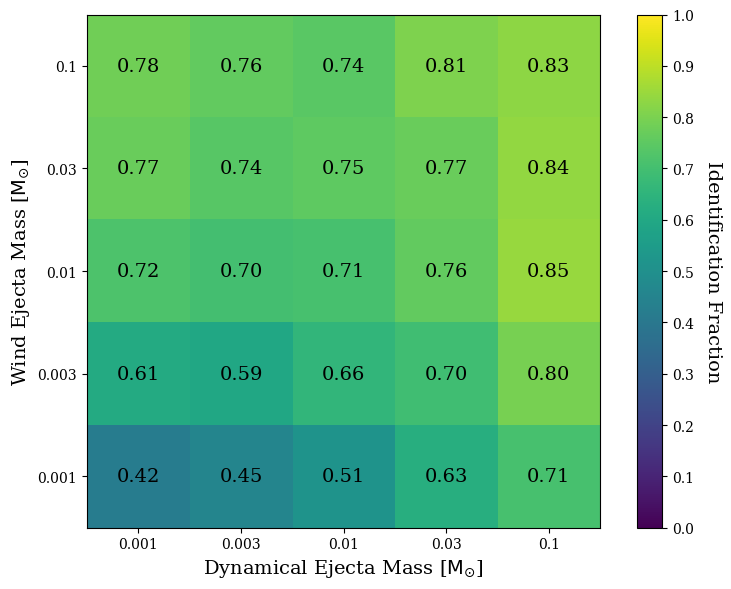

In [151]:
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(conf_matrix/conf_matrix_all, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)  # , cmap=plt.cm.Greens
cbar = fig.colorbar(cax, ticks=np.arange(0, 1.0+0.1, 0.1))
# cbar.set_label('Fraction Consistent with Upper Limits', rotation=270, fontsize=14, labelpad=20)
cbar.set_label('Identification Fraction', rotation=270, fontsize=14, labelpad=20)

_ = ax.set_xticks(np.arange(len(np.unique(arr0))), np.unique(arr0))
_ = ax.set_yticks(np.arange(len(np.unique(arr1))), np.flipud(np.unique(arr1)))
_ = ax.set_xlabel(labeldict[key0], fontsize=14)
_ = ax.set_ylabel(labeldict[key1], fontsize=14)

fmt = '1.2f'
thresh = 0.3
fs = 14 # fontsize
for i in range(conf_matrix.shape[0]):
	for j in range(conf_matrix.shape[1]):
		ax.text(j, i, format(conf_matrix[i, j]/conf_matrix_all[i, j], fmt), fontsize=fs, ha="center", va="center", color="white" if conf_matrix[i, j]/conf_matrix_all[i, j] < thresh else "black")  #horizontalalignment

plt.tight_layout()
# plt.savefig(f"{path_plot}/kn.ejecta_mass.constraint.png")
# plt.savefig(f"{path_plot}/kn.ejecta_mass.constraint.pdf")

0.16113636363636363 0.7027272727272726


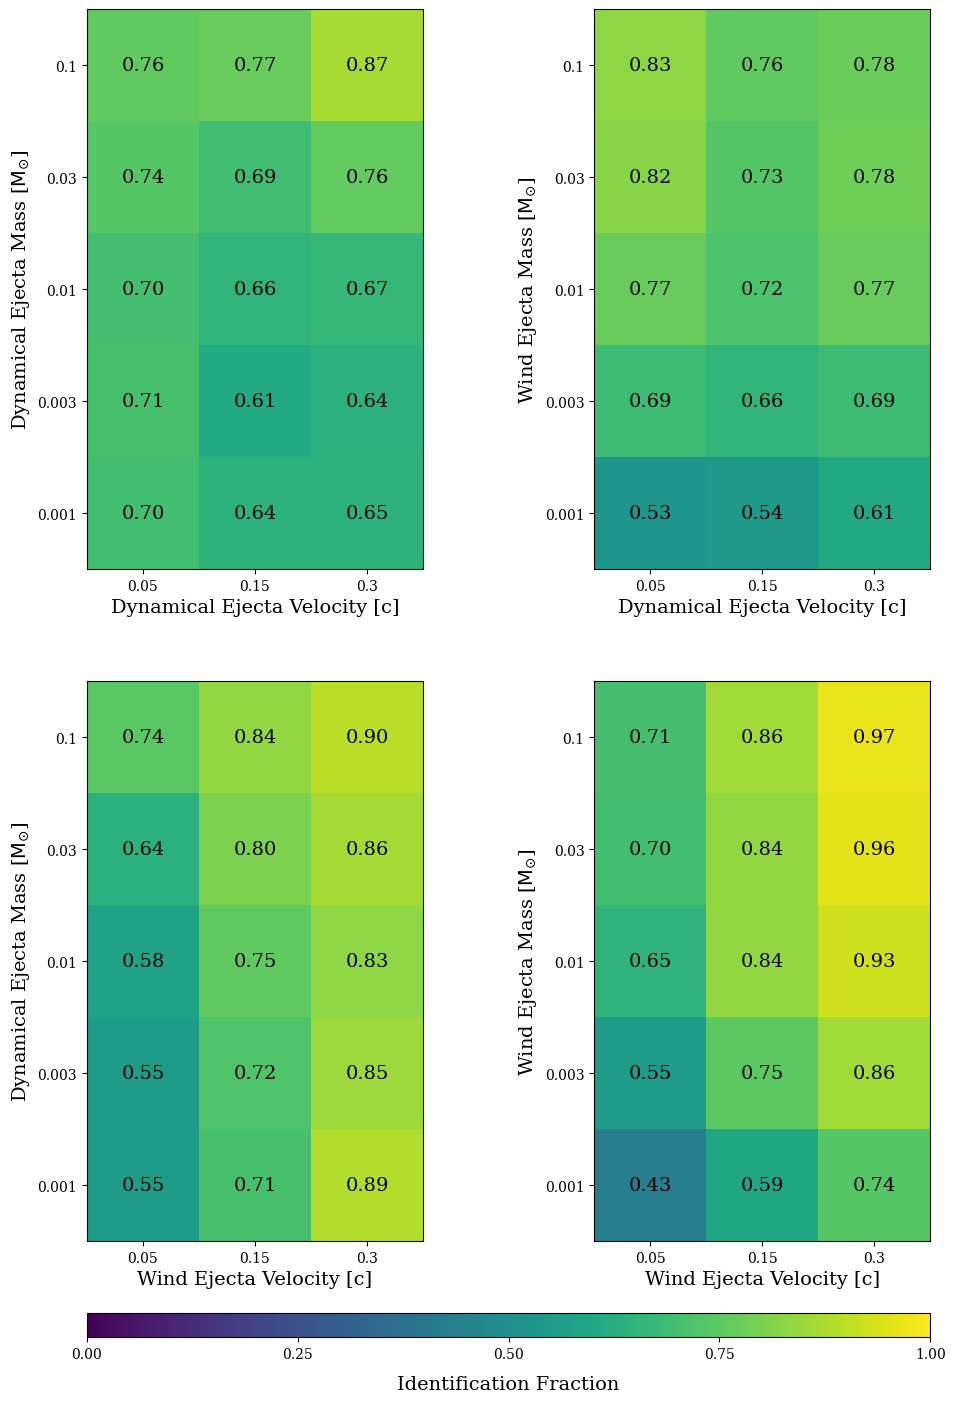

In [152]:
#	Plot
plt.close('all')
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(2, 2, figsize=(12, 16))
ax0, ax1, ax2, ax3 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]

#	Keys
keys0 = ['vd', 'vd', 'vw', 'vw']
keys1 = ['md', 'mw', 'md', 'mw']

for key0, key1, ax, in zip(keys0, keys1, [ax0, ax1, ax2, ax3],):

	arr0 = ilstbl[key0]
	arr1 = ilstbl[key1]
	alarr0 = flstbl[key0]
	alarr1 = flstbl[key1]
	(conf_matrix, conf_matrix_all) = make_confusion_matrix(arr0, arr1, alarr0, alarr1)

	cmap = plt.cm.viridis
	im = ax.imshow(conf_matrix/conf_matrix_all, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)  # , cmap=plt.cm.Greens

	_ = ax.set_xticks(np.arange(len(np.unique(arr0))), np.unique(arr0))
	_ = ax.set_yticks(np.arange(len(np.unique(arr1))), np.flipud(np.unique(arr1)))
	_ = ax.set_xlabel(labeldict[key0], fontsize=14)
	_ = ax.set_ylabel(labeldict[key1], fontsize=14)

	fmt = '1.2f'
	thresh = 0.3
	fs = 14 # fontsize
	for i in range(conf_matrix.shape[0]):
		for j in range(conf_matrix.shape[1]):
			ax.text(j, i, format(conf_matrix[i, j]/conf_matrix_all[i, j], fmt), fontsize=fs, ha="center", va="center", color="white" if conf_matrix[i, j]/conf_matrix_all[i, j] < thresh else "black")  #horizontalalignment

p0 = ax0.get_position().get_points().flatten()
p1 = ax1.get_position().get_points().flatten()
p2 = ax2.get_position().get_points().flatten()
p3 = ax3.get_position().get_points().flatten()

ax_cbar = fig.add_axes([p0[0], 0.05, (p1[2]-p0[0]), 0.015], aspect='auto')
print(p0[0], p1[2]-p0[0])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='horizontal', ticks=np.arange(0, 1.0+0.25, 0.25))
cbar.set_label('Identification Fraction', rotation=0, fontsize=14, labelpad=10)

# plt.savefig(f"{path_plot}/kn.all.constraint.png")
# plt.savefig(f"{path_plot}/kn.all.constraint.pdf")

# circular plot

In [153]:
len(lstbl[indx_skip])
len(lstbl[indx_nskip])

30815

([<matplotlib.patches.Wedge at 0x1778aecb0>,
 [Text(0.03641109332999324, 1.0993972131502403, 'Ib'),
  Text(0.18422431831504624, 1.0844636464821478, 'IIL'),
  Text(0.4307413547535694, 1.0121570457715838, 'IIb'),
  Text(0.7406983602175276, 0.8132440833913678, 'Ic'),
  Text(1.0541196291900954, 0.3143752651786331, 'Ia'),
  Text(0.9966371850339224, -0.465525854714493, 'IIn'),
  Text(-1.0245939354356075, -0.4002590004841546, 'IIP')],
 [Text(0.019860596361814493, 0.5996712071728583, '1.1%'),
  Text(0.10048599180820704, 0.5915256253538986, '3.2%'),
  Text(0.23494982986558327, 0.5520856613299547, '4.2%'),
  Text(0.4040172873913786, 0.44358768184983693, '6.5%'),
  Text(0.5749743431945974, 0.1714774173701635, '10.8%'),
  Text(0.5436202827457758, -0.2539231934806325, '12.4%'),
  Text(-0.5588694193285131, -0.2183230911731752, '61.9%')])

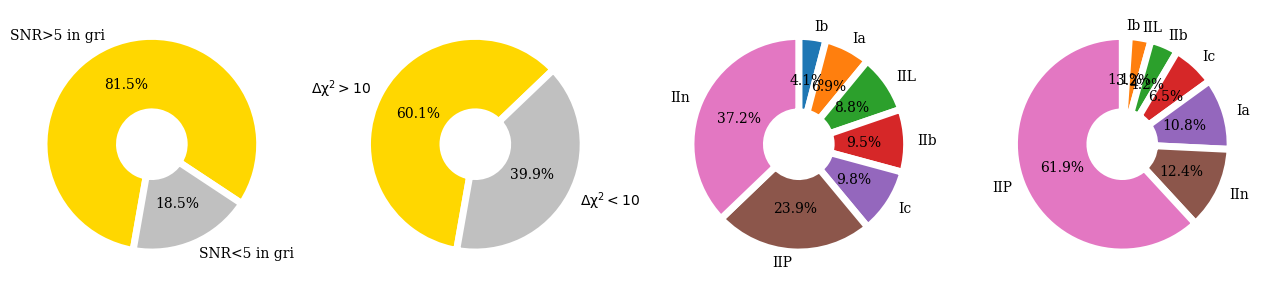

In [154]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 4))



plt.subplot(1, 4, 1)
ratio = [
	len(lstbl[indx_nskip]),
	len(lstbl[indx_skip]),
]
labels = ['SNR>5 in gri', 'SNR<5 in gri', 'Melon', 'Grapes'][:2]
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][:2]
colors = ['gold', 'silver',]
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)

plt.subplot(1, 4, 2)
ratio = [
	len(del_rchisq[del_rchisq>=10]),
	len(del_rchisq[del_rchisq<10]),
]
labels = [r'$\rm \Delta \chi^{2}>10$', r'$\rm \Delta \chi^{2}<10$', 'Melon', 'Grapes'][:2]
# colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][2:]
colors = ['gold', 'silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)

plt.subplot(1, 4, 3)
ratio = []
labels = []
for typ in np.unique(cmptbl['typ']):
	n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	# print(typ, n)
	ratio.append(n)
	labels.append(typ)

ratio = np.array(ratio)
labels = np.array(labels)[np.argsort(ratio)]
ratio = ratio[np.argsort(ratio)]

# labels = [r'$\rm \Delta \chi^{2}>10$', r'$\rm \Delta \chi^{2}<10$', 'Melon', 'Grapes'][:2]
# colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][2:]
# colors = ['gold', 'yellow']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=wedgeprops)


plt.subplot(1, 4, 4)
ratio = []
labels = []
for typ, wn in zip(np.unique(cmptbl['typ']), wnlist):
	# n = np.sum(cmptbl['n'][cmptbl['typ']==typ])
	# print(typ, n)
	ratio.append(wn)
	labels.append(typ)

ratio = np.array(ratio)
labels = np.array(labels)[np.argsort(ratio)]
ratio = ratio[np.argsort(ratio)]

# labels = [r'$\rm \Delta \chi^{2}>10$', r'$\rm \Delta \chi^{2}<10$', 'Melon', 'Grapes'][:2]
# colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0'][2:]
# colors = ['gold', 'yellow']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=90, counterclock=False, wedgeprops=wedgeprops)


In [156]:
mflstbl.write(f'../5.result/fit_kn2all/{tag}/fit.only.detect.fits', format='fits', overwrite=True)